In [1]:
from tqdm.notebook import tqdm
import pandas as pd
from datasets import Dataset
from src.dataset import SPFastaDatasetBinaryWithTokenizedCategory
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification
from os import path
from datasets import ClassLabel


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
model_name = "./model/checkpoint-final"
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [3]:
ds_type = SPFastaDatasetBinaryWithTokenizedCategory
def load_data(path: path) -> Dataset:
    ds = ds_type(path)
    return Dataset.from_pandas(ds.data).with_format("torch", device=device)
dataset_test = load_data("./data/test.fasta")
dataset_test = dataset_test.cast_column('labels', ClassLabel(num_classes = 2, names=["NO_SP", "SP"]))
dataset_test = dataset_test.map(lambda x: tokenizer(x['text'], return_tensors="pt", padding='max_length', max_length=81, truncation=True), batched=True)
dataset_test

100%|██████████| 8811/8811 [00:00<00:00, 629327.73it/s]


Casting the dataset:   0%|          | 0/8811 [00:00<?, ? examples/s]

Map:   0%|          | 0/8811 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', 'uniprot_ac', 'kingdom', 'type', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8811
})

In [4]:
import evaluate

def compute_metrics(eval_pred):
    # acc = evaluate.load("accuracy")
    pre = evaluate.load("precision")
    rec = evaluate.load("recall")
    f1m = evaluate.load("f1")

    metrics = [pre, rec, f1m]

    x, y = eval_pred
    return {k: v for metric in [m.compute(predictions=x, references=y) for m in metrics] for k, v in metric.items()}

In [5]:
res = []
for batch in tqdm(torch.utils.data.DataLoader(dataset_test, batch_size=8)):
    pred = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels']).logits.argmax(-1)
    for p, l, k in zip(pred, batch['labels'], batch['kingdom']):
        res.append({
            'eval_pred': (p.item(), l.item()),
            'kingdom': k
        })

  0%|          | 0/1102 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame([r['eval_pred'] for r in res], columns=['pred', 'label'])
metrics = compute_metrics(torch.tensor(df.values.T))
print(f"[Total]:\n{df.value_counts()}\n{metrics}\n")

[Total]:
pred  label
0     0        7562
1     1        1213
0     1          18
1     0          18
Name: count, dtype: int64
{'precision': 0.9853777416734363, 'recall': 0.9853777416734363, 'f1': 0.9853777416734363}



In [12]:
kingdoms = list(set(dataset_test['kingdom']))
metrics_dict = {}
for kingdom in kingdoms:
    df = pd.DataFrame([r['eval_pred'] for r in res if r['kingdom'] == kingdom], columns=['pred', 'label'])
    metrics = compute_metrics(torch.tensor(df.values.T))
    metrics_dict[kingdom] = metrics
    print(f"[{kingdom}]:\n{df.value_counts()}\n{metrics}\n")

[EUKARYA]:
pred  label
0     0        7234
1     1         201
      0          13
0     1           9
Name: count, dtype: int64
{'precision': 0.9392523364485982, 'recall': 0.9571428571428572, 'f1': 0.9481132075471698}

[POSITIVE]:
pred  label
1     1        298
0     0         88
      1          2
1     0          1
Name: count, dtype: int64
{'precision': 0.9966555183946488, 'recall': 0.9933333333333333, 'f1': 0.994991652754591}

[NEGATIVE]:
pred  label
1     1        623
0     0        150
      1          7
1     0          3
Name: count, dtype: int64
{'precision': 0.9952076677316294, 'recall': 0.9888888888888889, 'f1': 0.9920382165605095}

[ARCHAEA]:
pred  label
1     1        91
0     0        90
1     0         1
Name: count, dtype: int64
{'precision': 0.9891304347826086, 'recall': 1.0, 'f1': 0.994535519125683}



In [14]:
metric_types = ['precision', 'recall', 'f1']
for t in metric_types:
    std = np.var([m[t] for m in metrics_dict.values()])
    print(f"{t}: {std:.3e}")

precision: 5.631e-04
recall: 2.714e-04
f1: 3.936e-04


(0.8, 1.05)

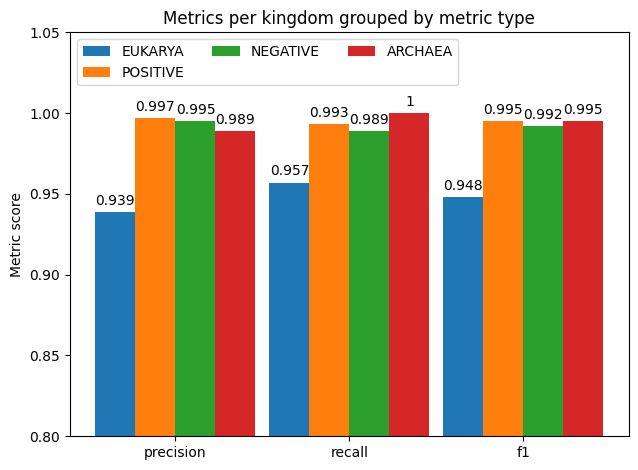

In [146]:
x = np.arange(3)
width = 0.23
multiplier = -0.5
fig, ax = plt.subplots()
for attribute, measurement in metrics_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement.values(), width, label=attribute)
    [rects.patches[i].set_height(np.round(rects.patches[i].get_height(), 3)) for i in range(len(rects.patches))]
    ax.bar_label(rects, padding=3)
    multiplier += 1
ax.set_ylabel('Metric score')
ax.set_title('Metrics per kingdom grouped by metric type')
ax.set_xticks(x + width, metric_types)

ax.legend(loc='upper left', ncols=3)
plt.tight_layout()

ax.set_ylim(0.8, 1.05)

In [ ]:
pd.DataFrame([r['eval_pred'] for r in res if r['kingdom'] == 'ARCHAEA'], columns=['pred', 'label']).value_counts()


pred  label
1     1        91
0     0        90
1     0         1
Name: count, dtype: int64